In this notebook we use Lasagne to train a classifier for handwritten digit
recognition (MNIST)

In [11]:
import os

os.environ['THEANO_FLAGS'] = 'device=gpu1, floatX=float32'

import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib
import theano
import theano.tensor as T

import pydot
from IPython.display import Image
from IPython.display import SVG
import timeit

import lasagne
import lasagne.layers as ll

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
# load MNIST data
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [36]:
# extract & reshape data
X_data, y_data = mnist['data'].reshape((-1,1,28,28)).astype(np.float32), mnist['target'].astype(np.int32)

# shuffle data
idx = np.arange(y_data.shape[0])
np.random.shuffle(idx)

X_data, y_data = X_data[idx], y_data[idx]

# split the dataset
X_train, X_test = X_data[:60000], X_data[60000:]
y_train, y_test = y_data[:60000], y_data[60000:]

**Excercise 1:** Draw a couple of sample from the training set and check that the
labels are correct.

**Excercise 2**: Build a three-layer network (2 convolutions, 1 dense layer) in Lasagne.

**Solution**

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

In [85]:
input_var = T.ftensor4('x')
target_var = T.ivector('y')

net = {}

net['input'] = ll.InputLayer((None,1,28,28), input_var)
net['conv1'] = ll.Conv2DLayer(net['input'], num_filters=16, filter_size=7)
net['pool1'] = ll.MaxPool2DLayer(net['conv1'], pool_size=2)
net['conv2'] = ll.Conv2DLayer(net['pool1'], num_filters=32, filter_size=7)
net['pool2'] = ll.MaxPool2DLayer(net['conv2'], pool_size=2)
net['predict'] = ll.DenseLayer(net['pool2'], num_units=10, nonlinearity=lasagne.nonlinearities.softmax)

**Excercise 2a: ** Define the cost function and compile a training and test function.

**Excercise 2b: ** Plot the histogram over the prediction and check that you are not in a saturating regime (i.e. only 0 or 1).

**Excercise 2c: ** If you are in a saturating regime, decrease the variance of the weights by adapting the initializiation.

**Solution**

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

In [86]:
p = ll.get_output(net['predict'])

cost = lasagne.objectives.categorical_crossentropy(p, target_var).mean()
acc  = lasagne.objectives.categorical_accuracy(p, target_var).mean()

params = ll.get_all_params(net['predict'])
updates = lasagne.updates.momentum(cost, params, learning_rate=0.01)

# compile training function in the standard way
train_fn = theano.function([input_var, target_var], [cost, acc], updates=updates)

# compile separate test function that does not update parameters
test_fn = theano.function([input_var, target_var], [cost, acc])

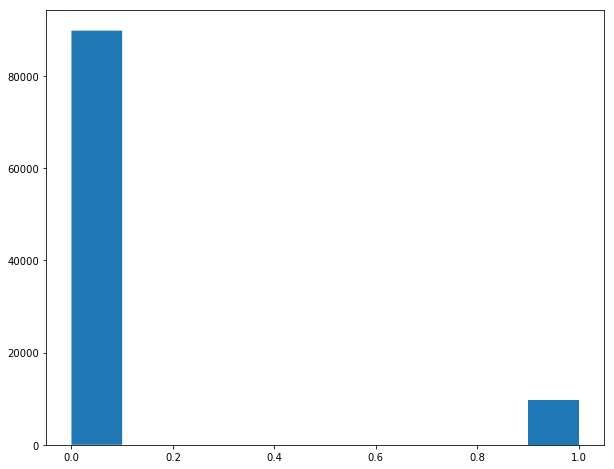

In [87]:
# output predictions before adapting the initial weight distribution
plt.hist(p.eval({input_var : X_test}).flatten())
plt.show()

In [88]:
# adapt initialization
net = {}

gain = 0.3

net['input'] = ll.InputLayer((None,1,28,28), input_var)
net['conv1'] = ll.Conv2DLayer(net['input'], num_filters=16, filter_size=7, 
                              W=lasagne.init.GlorotUniform(gain=gain))
net['pool1'] = ll.MaxPool2DLayer(net['conv1'], pool_size=2)
net['conv2'] = ll.Conv2DLayer(net['pool1'], num_filters=32, filter_size=7, 
                              W=lasagne.init.GlorotUniform(gain=gain))
net['pool2'] = ll.MaxPool2DLayer(net['conv2'], pool_size=2)
net['predict'] = ll.DenseLayer(net['pool2'], num_units=10, nonlinearity=lasagne.nonlinearities.softmax, 
                               W=lasagne.init.GlorotUniform(gain=gain))

In [89]:
p = ll.get_output(net['predict'])

cost = lasagne.objectives.categorical_crossentropy(p, target_var).mean()
acc  = lasagne.objectives.categorical_accuracy(p, target_var).mean()

params = ll.get_all_params(net['predict'])
updates = lasagne.updates.momentum(cost, params, learning_rate=0.001)

# compile training function in the standard way
train_fn = theano.function([input_var, target_var], [cost, acc], updates=updates)

# compile separate test function that does not update parameters
test_fn = theano.function([input_var, target_var], [cost, acc])

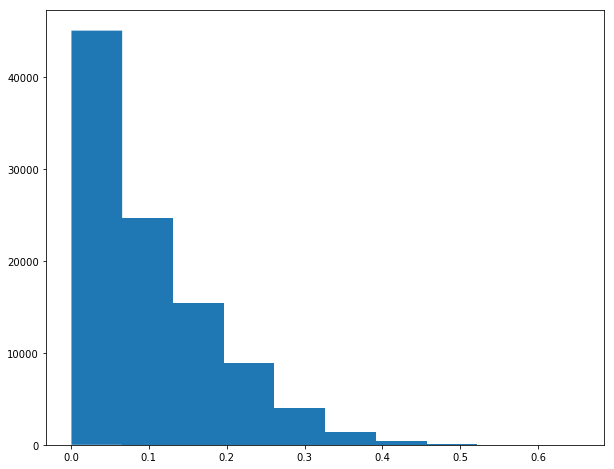

In [90]:
# output predictions before adapting the initial weight distribution
plt.hist(p.eval({input_var : X_test}).flatten())
plt.show()

**Excercise 3:** Train the network on **mini-batches** of size 100.

**Solution**

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

*

In [94]:
for epoch in range(25):
    epoch_cost, epoch_acc, k = 0, 0, 0
    # iterate over batch_index
    for bidx in range(60000/100):
        cost, acc = train_fn(X_train[bidx*100:(bidx+1)*100], y_train[bidx*100:(bidx+1)*100])
        epoch_cost += cost
        epoch_acc  += acc
        k += 1
        
    epoch_cost /= k
    epoch_acc  /= k
    
    print "Epoch ", str(epoch)
    print "Training performance: ", epoch_cost, epoch_acc
    
    test_cost, test_acc = test_fn(X_test, y_test)
    print "Validation performance: ", test_cost, test_acc

Epoch  0
Training performance:  0.000103646208147 1.0
Validation performance:  0.0613833069801 0.9909
Epoch  1
Training performance:  8.48476765818e-05 1.0
Validation performance:  0.0617880858481 0.9907
Epoch  2
Training performance:  7.49056907838e-05 1.0
Validation performance:  0.062119923532 0.9906


KeyboardInterrupt: 

**Excercise 3**: Play around with learning rates, update rules (e.g. Adam), regularizations (e.g. dropout) 
and different architectures. What is the best test performance you can get?

### Write your own Lasagne Layer

A big advantage of Lasagne is that you can easily write your own Lasagne Layers.

**Excercise 3**: Go through the [quick tutorial](http://lasagne.readthedocs.io/en/latest/user/custom_layers.html) in the Lasagne documentation on how to write your own Layers.

Take a look at the definition of the dense layer:

In [98]:
from lasagne.layers.base import Layer
from lasagne import init, nonlinearities

class DenseLayer(Layer):
    """
    lasagne.layers.DenseLayer(incoming, num_units,
    W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),
    nonlinearity=lasagne.nonlinearities.rectify, **kwargs)
    A fully connected layer.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape
    num_units : int
        The number of units of the layer
    W : Theano shared variable, expression, numpy array or callable
        Initial value, expression or initializer for the weights.
        These should be a matrix with shape ``(num_inputs, num_units)``.
        See :func:`lasagne.utils.create_param` for more information.
    b : Theano shared variable, expression, numpy array, callable or ``None``
        Initial value, expression or initializer for the biases. If set to
        ``None``, the layer will have no biases. Otherwise, biases should be
        a 1D array with shape ``(num_units,)``.
        See :func:`lasagne.utils.create_param` for more information.
    nonlinearity : callable or None
        The nonlinearity that is applied to the layer activations. If None
        is provided, the layer will be linear.
    Examples
    --------
    >>> from lasagne.layers import InputLayer, DenseLayer
    >>> l_in = InputLayer((100, 20))
    >>> l1 = DenseLayer(l_in, num_units=50)
    Notes
    -----
    If the input to this layer has more than two axes, it will flatten the
    trailing axes. This is useful for when a dense layer follows a
    convolutional layer, for example. It is not necessary to insert a
    :class:`FlattenLayer` in this case.
    """
    def __init__(self, incoming, num_units, W=init.GlorotUniform(),
                 b=init.Constant(0.), nonlinearity=nonlinearities.rectify,
                 **kwargs):
        super(DenseLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (nonlinearities.identity if nonlinearity is None
                             else nonlinearity)

        self.num_units = num_units

        num_inputs = int(np.prod(self.input_shape[1:]))

        self.W = self.add_param(W, (num_inputs, num_units), name="W")
        if b is None:
            self.b = None
        else:
            self.b = self.add_param(b, (num_units,), name="b",
                                    regularizable=False)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_units)

    def get_output_for(self, input, **kwargs):
        if input.ndim > 2:
            # if the input has more than two dimensions, flatten it into a
            # batch of feature vectors.
            input = input.flatten(2)

        activation = T.dot(input, self.W)
        if self.b is not None:
            activation = activation + self.b.dimshuffle('x', 0)
        return self.nonlinearity(activation)

**Excercise 4a:** Implement a layer that keeps the length of each feature vector (i.e. the input weights to each unit)
constant at 1.

**Bonus Excercise:** Implement the length of each feature vector as its own parameter.

In [99]:
class NormedDenseLayer(Layer):
    """
    lasagne.layers.DenseLayer(incoming, num_units,
    W=lasagne.init.GlorotUniform(), b=lasagne.init.Constant(0.),
    nonlinearity=lasagne.nonlinearities.rectify, **kwargs)
    A fully connected layer.
    Parameters
    ----------
    incoming : a :class:`Layer` instance or a tuple
        The layer feeding into this layer, or the expected input shape
    num_units : int
        The number of units of the layer
    W : Theano shared variable, expression, numpy array or callable
        Initial value, expression or initializer for the weights.
        These should be a matrix with shape ``(num_inputs, num_units)``.
        See :func:`lasagne.utils.create_param` for more information.
    b : Theano shared variable, expression, numpy array, callable or ``None``
        Initial value, expression or initializer for the biases. If set to
        ``None``, the layer will have no biases. Otherwise, biases should be
        a 1D array with shape ``(num_units,)``.
        See :func:`lasagne.utils.create_param` for more information.
    nonlinearity : callable or None
        The nonlinearity that is applied to the layer activations. If None
        is provided, the layer will be linear.
    Examples
    --------
    >>> from lasagne.layers import InputLayer, DenseLayer
    >>> l_in = InputLayer((100, 20))
    >>> l1 = DenseLayer(l_in, num_units=50)
    Notes
    -----
    If the input to this layer has more than two axes, it will flatten the
    trailing axes. This is useful for when a dense layer follows a
    convolutional layer, for example. It is not necessary to insert a
    :class:`FlattenLayer` in this case.
    """
    def __init__(self, incoming, num_units, W=init.GlorotUniform(),
                 b=init.Constant(0.), nonlinearity=nonlinearities.rectify,
                 **kwargs):
        super(NormedDenseLayer, self).__init__(incoming, **kwargs)
        self.nonlinearity = (nonlinearities.identity if nonlinearity is None
                             else nonlinearity)

        self.num_units = num_units

        num_inputs = int(np.prod(self.input_shape[1:]))

        self.W = self.add_param(W, (num_inputs, num_units), name="W")
        if b is None:
            self.b = None
        else:
            self.b = self.add_param(b, (num_units,), name="b",
                                    regularizable=False)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0], self.num_units)

    def get_output_for(self, input, **kwargs):
        if input.ndim > 2:
            # if the input has more than two dimensions, flatten it into a
            # batch of feature vectors.
            input = input.flatten(2)

        W = self.W / T.sqrt((self.W**2).sum(1)).dimshuffle([0, 'x'])
        activation = T.dot(input, W)
        if self.b is not None:
            activation = activation + self.b.dimshuffle('x', 0)
        return self.nonlinearity(activation)

In [100]:
# test
# adapt initialization
net = {}

gain = 0.3

net['input'] = ll.InputLayer((None,1,28,28), input_var)
net['conv1'] = ll.Conv2DLayer(net['input'], num_filters=16, filter_size=7, 
                              W=lasagne.init.GlorotUniform(gain=gain))
net['pool1'] = ll.MaxPool2DLayer(net['conv1'], pool_size=2)
net['conv2'] = ll.Conv2DLayer(net['pool1'], num_filters=32, filter_size=7, 
                              W=lasagne.init.GlorotUniform(gain=gain))
net['pool2'] = ll.MaxPool2DLayer(net['conv2'], pool_size=2)
net['predict'] = NormedDenseLayer(net['pool2'], num_units=10, nonlinearity=lasagne.nonlinearities.softmax, 
                               W=lasagne.init.GlorotUniform(gain=gain))

In [101]:
p = ll.get_output(net['predict'])

cost = lasagne.objectives.categorical_crossentropy(p, target_var).mean()
acc  = lasagne.objectives.categorical_accuracy(p, target_var).mean()

params = ll.get_all_params(net['predict'])
updates = lasagne.updates.momentum(cost, params, learning_rate=0.001)

# compile training function in the standard way
train_fn = theano.function([input_var, target_var], [cost, acc], updates=updates)

# compile separate test function that does not update parameters
test_fn = theano.function([input_var, target_var], [cost, acc])

In [102]:
for epoch in range(25):
    epoch_cost, epoch_acc, k = 0, 0, 0
    # iterate over batch_index
    for bidx in range(60000/100):
        cost, acc = train_fn(X_train[bidx*100:(bidx+1)*100], y_train[bidx*100:(bidx+1)*100])
        epoch_cost += cost
        epoch_acc  += acc
        k += 1
        
    epoch_cost /= k
    epoch_acc  /= k
    
    print "Epoch ", str(epoch)
    print "Training performance: ", epoch_cost, epoch_acc
    
    test_cost, test_acc = test_fn(X_test, y_test)
    print "Validation performance: ", test_cost, test_acc

Epoch  0
Training performance:  0.614844428829 0.851983333333
Validation performance:  0.240344464779 0.9281
Epoch  1
Training performance:  0.217815038146 0.937683333333
Validation performance:  0.212990552187 0.9479
Epoch  2
Training performance:  0.179053503269 0.949466666667
Validation performance:  0.187772169709 0.95
Epoch  3
Training performance:  0.160185345652 0.954616666667
Validation performance:  0.14772477746 0.9602
Epoch  4
Training performance:  0.151376889832 0.956716666667
Validation performance:  0.171485871077 0.9545
Epoch  5
Training performance:  0.142938228104 0.958966666667
Validation performance:  0.176893934608 0.9572
Epoch  6
Training performance:  0.144608001243 0.960066666667
Validation performance:  0.14722533524 0.9644
Epoch  7
Training performance:  0.14260520929 0.960366666667
Validation performance:  0.148414209485 0.9639
Epoch  8
Training performance:  0.133126702275 0.963016666667
Validation performance:  0.17935217917 0.9591
Epoch  9
Training perform